# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile
from zipfile import ZipFile

from PIL import Image, ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import numpy as np

#loading file needed filepaths
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
my_font = ImageFont.truetype('readonly/fanwood-webfont.ttf', 15)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'
file_path1 = 'readonly/small_img.zip'
file_path2 = 'readonly/images.zip'
    

In [4]:
def textLine(file, int): #create and append box with text introducing page results. file is the filename for the page being searched. int defines what text is needed
    textBox = Image.new('L', (500, 30), color = 'white')
    header = ImageDraw.Draw(textBox)
    if int == 1:
        header.text((5, 5),  'Result for file {}'.format(file), fill = 'black', font = my_font)
        return textBox
    elif int == 2:
        header.text((5, 5),  'Search term occured but no faces were found.', fill = 'black', font = my_font)
        return textBox
    else:
        header.text((5, 5),  'Search term not found in file {}.'.format(file) , fill = 'black', font = my_font)
        return textBox


def partialContact(input): #takes list of faces from a single page and appends them to an image
    if input[0].height < 40: #this distinguishes the textbox (size 30) that says no faces were found from lists of faces
      pageImage = Image.new('L', (500, 80), color = 'black')
      pos = 0
      for img in input:
        pageImage.paste(img, (pos, 0))
        pos += img.height
    else:
      h = 100 #default hight is 100. add another row of 100 for every 5 additional faces
      numImg = 1
      #get height for each img in inputs for creating final image
      for img in input:  
        if numImg > 5:
            h += 100
            numImg = 1
        else:
            numImg += 1
      pageImage = Image.new('L', (500, h), color = 'black') #create contact sheet for page of newspaper, with the needed height
      y = 0
      pos = 0
      for img in input: #make sure we display our pics 5 across
        if pos < 500:
          pageImage.paste(img, (pos, y))
          pos += 100
        else:
          pos = 0
          y += 100
          pageImage.paste(img, (pos, y))
          pos += 100
    return pageImage
    
def finalContact (pageResults):    
  height = 0  
  #get height for each img in inputs for creating final image. some images will be textboxes, some will be partialc contact sheets of various sizes
  for img in pageResults:
    height += img.height
  #create final image w/dimensions heightx500
  finalSheet = Image.new('L', (500, height), color = 'white')
  #paste img into the final contact sheet
  pos = 0
  for img in pageResults:
    finalSheet.paste(img, (0, pos))
    pos += img.height
  return finalSheet

In [1]:
def name_and_faces(file_path, search_term):
  imageList = [] #this will hold a list of contact sheets for each page of the paper

  #extract zip file and load file names into an array
  with ZipFile(file_path, 'r') as zipObj:
   filenames = zipObj.namelist() #load filenames for files into a list
   length = len(filenames)
   for x in range(length):
     file = zipObj.extract(filenames[x]) #extract the zip files

  for fileName in filenames:  
   #open each file and search for our keywords    
   img = Image.open(fileName)
   img = img.convert('L')
   imgCV = np.array(img)
   text = pytesseract.image_to_string(img)
   foundFaces = [] #clear each time to prevent old faces on new page of contact sheet
   drawing=ImageDraw.Draw(img)
   #add page header to imageList = textLine(filename[x], 1)
   imageList.append(textLine(fileName, 1))
   
   #search text for keywords
   if search_term in text:
     #if the name is found on the page, call function to search the page of faces and return a contact sheet of the faces
     faces = face_cascade.detectMultiScale(imgCV, 1.3, 5) #I played witht he paramaters until I got similar results to the instructor
     for x,y,w,h in faces:
       facebox = img.crop((x, y, x+w, y+h))
       facebox.thumbnail((100,100)) #resize face to fit contactsheet rows
       foundFaces.append(facebox) #make a list of faces to unpack to the contact sheet.
            
     if foundFaces:
        imageList.append(partialContact(foundFaces))
     else:
         #append text to contact sheet that there were no faces but the words occured
         imageList.append(textLine(fileName, 2))
   else:
     #append text that the words do not occur to final image list
     imageList.append(textLine(fileName, 3))
  
  display(finalContact(imageList))


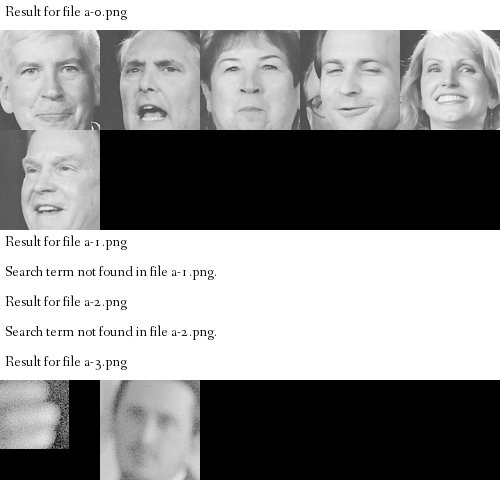

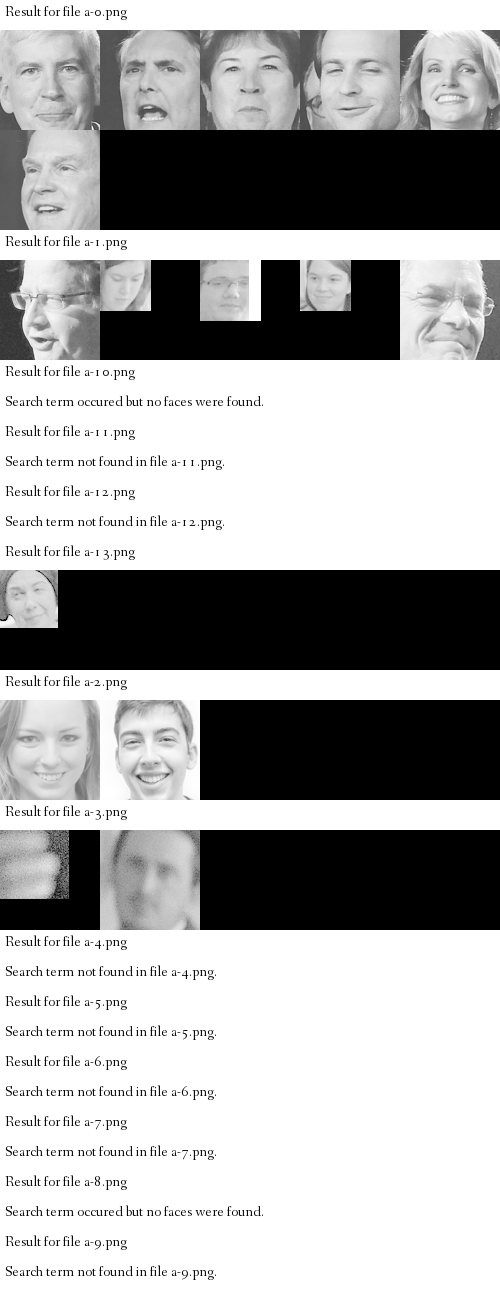

In [6]:
#call the function to search the two zips for our two terms
name_and_faces(file_path1, 'Christopher')
name_and_faces(file_path2, 'Mark')
